# ML models assessment

### Import libraries

In [106]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

### Import dataset

In [107]:
data = pd.read_csv('../../datasets/data-stemmed.csv')
data.info()
nan_count = data['processed text'].isnull().sum()
print(f'Number of NaN values: {nan_count}') # 2 NaN values (non so il perchè, nel file di stemming non uscivano)
print(f'Number of rows: {len(data)}')
data = data.dropna(subset=['processed text'])
print(f'Number of rows after dropping NaN values: {len(data)}')
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4979 entries, 0 to 4978
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   text                 4977 non-null   object 
 1   quotes               4979 non-null   int64  
 2   is.retweet           4979 non-null   bool   
 3   external.link        4979 non-null   bool   
 4   pictures             4979 non-null   bool   
 5   videos               4979 non-null   bool   
 6   gifs                 4979 non-null   bool   
 7   multimedial_content  4979 non-null   bool   
 8   user.image           4979 non-null   bool   
 9   user.bio             4979 non-null   bool   
 10  user.website         4979 non-null   bool   
 11  user.tweets          4979 non-null   int64  
 12  user.following       4979 non-null   int64  
 13  user.media           4979 non-null   int64  
 14  engagement.rate      4979 non-null   float64
 15  n_hashtags           4979 non-null   i

,text,quotes,is.retweet,external.link,pictures,videos,gifs,multimedial_content,user.image,user.bio,user.website,user.tweets,user.following,user.media,engagement.rate,n_hashtags,processed text
0,Fried Chicken with Hot 🔥 Sauce Corn Muffin and...,1,True,False,True,False,False,True,True,True,True,16213,549,15698,-515.787662,8,fri chicken hot fire sauc corn muffin season f...
1,#Morel #mushrooms at center of #food #poisonin...,0,False,False,False,False,False,False,True,True,True,50098,513,1962,-747.022414,10,morel mushroom center food poison outbreak fun...
2,My Blog:: Obama Legacy Facing REVISIT ... Ian...,0,False,False,False,False,False,False,True,True,True,5174,9022,0,-867.658724,11,blog obama legaci face revisit ianrmackintoshb...
3,Craving sushi but tired of expensive takeout? ...,0,False,False,False,False,False,False,True,True,True,108071,678,49647,-870.880480,6,crave sushi tire expens takeout look kellylov ...
4,Potato Pancakes should not be a rare side dish...,0,False,False,True,False,False,True,True,True,True,28081,2343,18032,-835.161075,8,potato pancak rare side dish plan leftov time ...


### Perform vectrorization

Perform here the division between covariates and target variable in order to easen the code later on

In [108]:
data.drop(['text'], axis=1, inplace=True)
Y = data['engagement.rate']
data['engagement.rate'].fillna(data['engagement.rate'].mean(), inplace=True)
X = data.drop(columns=['engagement.rate'])
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4977 entries, 0 to 4978
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   quotes               4977 non-null   int64 
 1   is.retweet           4977 non-null   bool  
 2   external.link        4977 non-null   bool  
 3   pictures             4977 non-null   bool  
 4   videos               4977 non-null   bool  
 5   gifs                 4977 non-null   bool  
 6   multimedial_content  4977 non-null   bool  
 7   user.image           4977 non-null   bool  
 8   user.bio             4977 non-null   bool  
 9   user.website         4977 non-null   bool  
 10  user.tweets          4977 non-null   int64 
 11  user.following       4977 non-null   int64 
 12  user.media           4977 non-null   int64 
 13  n_hashtags           4977 non-null   int64 
 14  processed text       4977 non-null   object
dtypes: bool(9), int64(5), object(1)
memory usage: 315.9+ KB


In [109]:
# label encoding
# max_df will be set with regard of the best parameter found in the previous step
vectorizer = TfidfVectorizer(min_df=2, max_df=0.99, max_features=1000) # ignore terms that appear in more than 99% of the documents and in less than 2 documents

dtm = vectorizer.fit_transform(X['processed text'])
# DTM is a document-term matrix with shape (n_samples, n_features) having as rows the documents and as columns the terms learned as vocabulary
# The value of each cell is the tf-idf score


# Convert sparse matrix to dense matrix
dense_matrix = dtm.toarray()

# Display non-zero elements
non_zero_elements = dense_matrix[dense_matrix != 0]
print(len(non_zero_elements))
print(non_zero_elements)

# Convert the DTM to a dataframe
dtm_df = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())

# # Calculate the threshold for removal
# threshold = 0.001 * len(X)  # For example, keep terms that appear in at least 1% of documents
# dtm_df = dtm_df.loc[:, dtm_df.sum() >= threshold]

# Merge the two dataframes
# Reset the indexes of both X and dtm_df
X.reset_index(drop=True, inplace=True)
dtm_df.reset_index(drop=True, inplace=True)

# Concatenate the DataFrames
merged_df = pd.concat([X, dtm_df], axis=1)
X.fillna(0, inplace=True)
flag=False
if 'engagement.rate' in X.columns:
    flag = True
print(f'{flag}')
merged_df.head(5)

42952
[0.19744871 0.30159379 0.22836195 ... 0.25969716 0.23140797 0.9728568 ]


False


,quotes,is.retweet,external.link,pictures,videos,gifs,multimedial_content,user.image,user.bio,user.website,...,των,سے,فوڈ,میں,کا,کی,کے,खन,おうちごはん,美食
0,1,True,False,True,False,False,True,True,True,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,False,False,False,False,False,False,True,True,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,False,False,False,False,False,False,True,True,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,False,False,False,False,False,False,True,True,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,False,False,True,False,False,True,True,True,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Drop the text column, as processed text will be the covariate of interest.
Then perform the X, Y division, where Y will be engagement rate

In [110]:
X.drop(columns=['processed text'], inplace=True)
cols = X.columns.tolist()
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=cols)
X.head(5)

,quotes,is.retweet,external.link,pictures,videos,gifs,multimedial_content,user.image,user.bio,user.website,user.tweets,user.following,user.media,n_hashtags
0,-0.037794,1.364547,-0.100738,1.075801,-0.373394,-0.09552,0.825137,0.0,0.263444,0.791163,-0.179522,-0.245358,0.043099,0.400609
1,-0.042744,-0.732844,-0.100738,-0.929540,-0.373394,-0.09552,-1.211920,0.0,0.263444,0.791163,0.022623,-0.251110,-0.063984,0.749486
2,-0.042744,-0.732844,-0.100738,-0.929540,-0.373394,-0.09552,-1.211920,0.0,0.263444,0.791163,-0.245376,1.108502,-0.079279,0.923925
3,-0.042744,-0.732844,-0.100738,-0.929540,-0.373394,-0.09552,-1.211920,0.0,0.263444,0.791163,0.368467,-0.224746,0.307759,0.051732
4,-0.042744,-0.732844,-0.100738,1.075801,-0.373394,-0.09552,0.825137,0.0,0.263444,0.791163,-0.108722,0.041297,0.061295,0.400609


In [111]:
# dataframe for storing results in a convenient way for shwing boxplot later
reg_metrics = pd.DataFrame(columns=['Model', 'MAE', 'RMSE', 'MAPE', 'R2'])

### Dummy regressor

We are going to use a dummy regressor (that estimates the mean of the output variable) as a baseline.

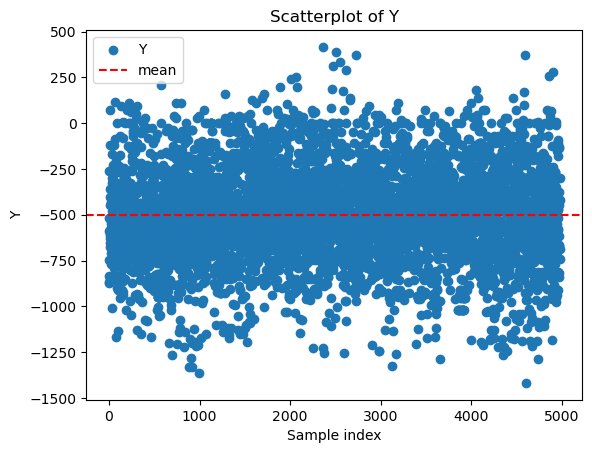

MSE Scores: 0    257.794899
1    261.949734
2    261.468569
3    251.635930
4    246.289814
5    263.681241
6    256.220332
7    263.108114
8    248.569982
9    267.066898
Name: RMSE, dtype: float64
Mean MSE: 257.7785514166964


In [112]:
dummy_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in dummy_kfolds.split(X):
    dummy_regressor = DummyRegressor()
    dummy_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_dummy_reg = dummy_regressor.predict(X.iloc[test_idx])
    current_dummy_mae = mean_absolute_error(Y.iloc[test_idx], y_dummy_reg)
    current_dummy_mse = mean_squared_error(Y.iloc[test_idx], y_dummy_reg)
    current_dummy_rmse = np.sqrt(current_dummy_mse)
    current_dummy_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_dummy_reg)
    current_dummy_r2 = r2_score(Y.iloc[test_idx], y_dummy_reg)
    reg_metrics.loc[len(reg_metrics)] = ['DUMMY', current_dummy_mae, current_dummy_rmse, current_dummy_mape, current_dummy_r2]

# Dovrebbe essere lo stesso di fare:
# lin_regressor = LinearRegression()
# Y_reshaped = Y.values.reshape(-1, 1)

# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(lin_regressor, np.ones_like(Y_reshaped), Y_reshaped,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(lin_regressor, np.ones_like(Y_reshaped), Y_reshaped, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(lin_regressor, np.ones_like(Y_reshaped), Y_reshaped, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics.loc[len(reg_metrics)] = ['DUMMY', mae_scores, mse_scores, mape_scores]


#Scatterplot of Y
mean_y = np.mean(Y)
plt.scatter(np.arange(len(Y)), Y, label='Y')
plt.axhline(y=mean_y, color='r', linestyle='--', label='mean')    # Plot the mean
plt.title('Scatterplot of Y')
plt.xlabel('Sample index')
plt.ylabel('Y')
plt.legend()
plt.show()

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics.loc[reg_metrics['Model']=='DUMMY','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics.loc[reg_metrics['Model']=='DUMMY','RMSE'])}")

We can see that the dummy classifier doesn't do much, as with few outliers, but that generates much leverage, the MSE is indeed very high

## Single decision tree

In [113]:
# Decision Tree Regressor
# Initialize a decision tree regressor instance
tree_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in tree_kfolds.split(X):
    tree_regressor = DecisionTreeRegressor()
    tree_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_tree_reg = tree_regressor.predict(X.iloc[test_idx])
    current_tree_mae = mean_absolute_error(Y.iloc[test_idx], y_tree_reg)
    current_tree_mse = mean_squared_error(Y.iloc[test_idx], y_tree_reg)
    current_tree_rmse = np.sqrt(current_tree_mse)
    current_tree_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_tree_reg)
    current_tree_r2 = r2_score(Y.iloc[test_idx], y_tree_reg)
    reg_metrics.loc[len(reg_metrics)] = ['TREE', current_tree_mae, current_tree_rmse, current_tree_mape, current_tree_r2]

# Dovrebbe essere lo stesso di fare:
# rf = RandomForestRegressor()
#
# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(rd, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(rf, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(rf, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics.loc[len(reg_metrics)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics.loc[reg_metrics['Model']=='TREE','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics.loc[reg_metrics['Model']=='TREE','RMSE'])}")

MSE Scores: 10    182.904108
11    175.754472
12    191.092282
13    177.235063
14    176.530372
15    190.255253
16    183.017361
17    180.727989
18    181.785450
19    180.085832
Name: RMSE, dtype: float64
Mean MSE: 181.93881806909056


## RandomForest

In [114]:
# Random Forest Regressor
# Initialize a random forest regressor instance
rf_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in rf_kfolds.split(X):
    rf_regressor = RandomForestRegressor()
    rf_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_rf_reg = rf_regressor.predict(X.iloc[test_idx])
    current_rf_mae = mean_absolute_error(Y.iloc[test_idx], y_rf_reg)
    current_rf_mse = mean_squared_error(Y.iloc[test_idx], y_rf_reg)
    current_rf_rmse = np.sqrt(current_rf_mse)
    current_rf_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_rf_reg)
    current_rf_r2 = r2_score(Y.iloc[test_idx], y_rf_reg)
    reg_metrics.loc[len(reg_metrics)] = ['RF', current_rf_mae, current_rf_rmse, current_rf_mape, current_rf_r2]
     
# Dovrebbe essere lo stesso di fare:
# dummy_regressor = DummyRegressor()

# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(lin_regressor, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(lin_regressor, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(lin_regressor, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics.loc[len(reg_metrics)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics.loc[reg_metrics['Model']=='RF','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics.loc[reg_metrics['Model']=='RF','RMSE'])}")

MSE Scores: 20    131.003371
21    148.468773
22    138.552424
23    132.945958
24    131.219350
25    125.104376
26    150.874147
27    141.039197
28    134.880340
29    138.954823
Name: RMSE, dtype: float64
Mean MSE: 137.3042758453759


## SVM

In [115]:
sv_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in sv_kfolds.split(X):
    sv_regressor = SVR()
    sv_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_sv_reg = sv_regressor.predict(X.iloc[test_idx])
    current_sv_mae = mean_absolute_error(Y.iloc[test_idx], y_sv_reg)
    current_sv_mse = mean_squared_error(Y.iloc[test_idx], y_sv_reg)
    current_sv_rmse = np.sqrt(current_sv_mse)
    current_sv_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_sv_reg)
    current_sv_r2 = r2_score(Y.iloc[test_idx], y_sv_reg)
    reg_metrics.loc[len(reg_metrics)] = ['SVM', current_sv_mae, current_sv_rmse, current_sv_mape, current_sv_r2]

# Dovrebbe essere lo stesso di fare:
# sv_regressor = SVR()
#
# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(sv_regressor, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(sv_regressor, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(sv_regressor, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics.loc[len(reg_metrics)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics.loc[reg_metrics['Model']=='SVM','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics.loc[reg_metrics['Model']=='SVM','RMSE'])}")

MSE Scores: 30    230.419143
31    244.000168
32    229.174152
33    237.101494
34    229.115915
35    241.136212
36    239.379941
37    242.646849
38    240.553442
39    241.410080
Name: RMSE, dtype: float64
Mean MSE: 237.4937394954918


## kNearestNeighbor

In [116]:
knn_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in knn_kfolds.split(X):
    knn_regressor = KNeighborsRegressor()
    knn_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_knn_reg = knn_regressor.predict(X.iloc[test_idx])
    current_knn_mae = mean_absolute_error(Y.iloc[test_idx], y_knn_reg)
    current_knn_mse = mean_squared_error(Y.iloc[test_idx], y_knn_reg)
    current_knn_rmse = np.sqrt(current_knn_mse)
    current_knn_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_knn_reg)
    current_knn_r2 = r2_score(Y.iloc[test_idx], y_knn_reg)
    reg_metrics.loc[len(reg_metrics)] = ['KNN', current_knn_mae, current_knn_rmse, current_knn_mape, current_knn_r2]

# Dovrebbe essere lo stesso di fare:
# knn_regressor = KNeighborsRegressor()
#
# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(knn_regressor, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(knn_regressor, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(knn_regressor, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics.loc[len(reg_metrics)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics.loc[reg_metrics['Model']=='KNN','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics.loc[reg_metrics['Model']=='KNN','RMSE'])}")

MSE Scores: 40    180.530775
41    172.260232
42    180.197733
43    188.526509
44    194.929490
45    180.565063
46    167.260651
47    183.651998
48    191.937816
49    171.951077
Name: RMSE, dtype: float64
Mean MSE: 181.181134289765


## Some plots

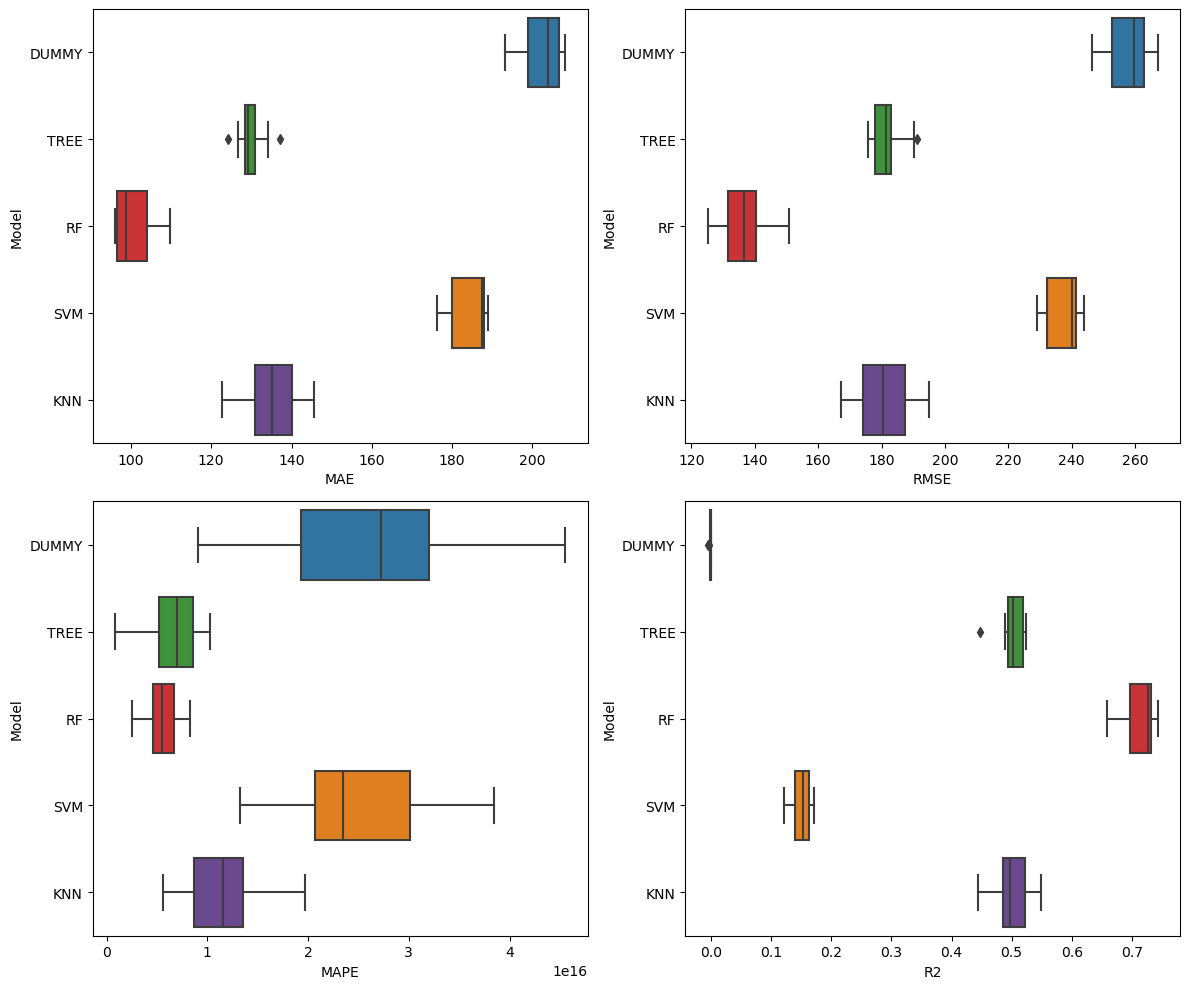

In [117]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
sns.boxplot(data=reg_metrics, x="MAE", y="Model", ax=axs[0, 0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics, x="RMSE", y="Model", ax=axs[0, 1], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics, x="MAPE", y="Model", ax=axs[1, 0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics, x="R2", y="Model", ax=axs[1, 1], palette=sns.color_palette('Paired')[1::2])


plt.tight_layout()
plt.show()

## Use only multimedial data

In [118]:
X.info()
X.drop(columns=['pictures', 'videos', 'gifs'], inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4977 entries, 0 to 4976
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   quotes               4977 non-null   float64
 1   is.retweet           4977 non-null   float64
 2   external.link        4977 non-null   float64
 3   pictures             4977 non-null   float64
 4   videos               4977 non-null   float64
 5   gifs                 4977 non-null   float64
 6   multimedial_content  4977 non-null   float64
 7   user.image           4977 non-null   float64
 8   user.bio             4977 non-null   float64
 9   user.website         4977 non-null   float64
 10  user.tweets          4977 non-null   float64
 11  user.following       4977 non-null   float64
 12  user.media           4977 non-null   float64
 13  n_hashtags           4977 non-null   float64
dtypes: float64(14)
memory usage: 544.5 KB


In [119]:
reg_metrics_new = pd.DataFrame(columns=['Model', 'MAE', 'RMSE', 'MAPE', 'R2'])

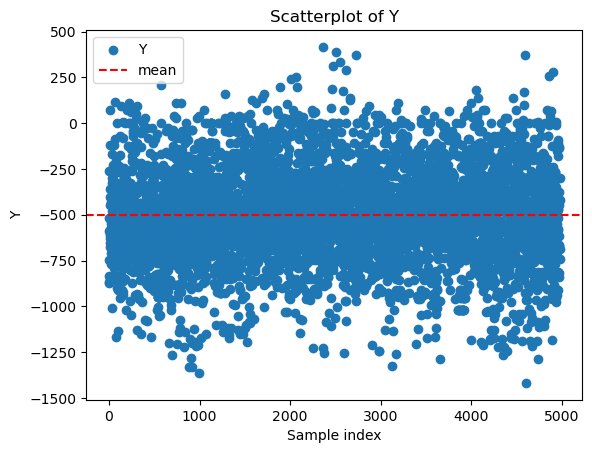

MSE Scores: 0    260.424332
1    272.425850
2    249.926280
3    268.360305
4    257.662813
5    267.465662
6    242.966106
7    246.603398
8    259.366592
9    251.876678
Name: RMSE, dtype: float64
Mean MSE: 257.70780135468084


In [120]:
dummy_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in dummy_kfolds.split(X):
    dummy_regressor = DummyRegressor()
    dummy_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_dummy_reg = dummy_regressor.predict(X.iloc[test_idx])
    current_dummy_mae = mean_absolute_error(Y.iloc[test_idx], y_dummy_reg)
    current_dummy_mse = mean_squared_error(Y.iloc[test_idx], y_dummy_reg)
    current_dummy_rmse = np.sqrt(current_dummy_mse)
    current_dummy_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_dummy_reg)
    current_dummy_r2 = r2_score(Y.iloc[test_idx], y_dummy_reg)
    reg_metrics_new.loc[len(reg_metrics_new)] = ['DUMMY', current_dummy_mae, current_dummy_rmse, current_dummy_mape, current_dummy_r2]

# Dovrebbe essere lo stesso di fare:
# lin_regressor = LinearRegression()
# Y_reshaped = Y.values.reshape(-1, 1)

# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(lin_regressor, np.ones_like(Y_reshaped), Y_reshaped,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(lin_regressor, np.ones_like(Y_reshaped), Y_reshaped, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(lin_regressor, np.ones_like(Y_reshaped), Y_reshaped, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics_new.loc[len(reg_metrics_new)] = ['DUMMY', mae_scores, mse_scores, mape_scores]


#Scatterplot of Y
mean_y = np.mean(Y)
plt.scatter(np.arange(len(Y)), Y, label='Y')
plt.axhline(y=mean_y, color='r', linestyle='--', label='mean')    # Plot the mean
plt.title('Scatterplot of Y')
plt.xlabel('Sample index')
plt.ylabel('Y')
plt.legend()
plt.show()

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics_new.loc[reg_metrics_new['Model']=='DUMMY','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics_new.loc[reg_metrics_new['Model']=='DUMMY','RMSE'])}")

In [121]:
# Decision Tree Regressor
# Initialize a decision tree regressor instance
tree_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in tree_kfolds.split(X):
    tree_regressor = DecisionTreeRegressor()
    tree_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_tree_reg = tree_regressor.predict(X.iloc[test_idx])
    current_tree_mae = mean_absolute_error(Y.iloc[test_idx], y_tree_reg)
    current_tree_mse = mean_squared_error(Y.iloc[test_idx], y_tree_reg)
    current_tree_rmse = np.sqrt(current_tree_mse)
    current_tree_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_tree_reg)
    current_tree_r2 = r2_score(Y.iloc[test_idx], y_tree_reg)
    reg_metrics_new.loc[len(reg_metrics_new)] = ['TREE', current_tree_mae, current_tree_rmse, current_tree_mape, current_tree_r2]

# Dovrebbe essere lo stesso di fare:
# rf = RandomForestRegressor()
#
# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(rd, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(rf, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(rf, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics_new.loc[len(reg_metrics_new)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics_new.loc[reg_metrics_new['Model']=='TREE','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics_new.loc[reg_metrics_new['Model']=='TREE','RMSE'])}")

MSE Scores: 10    173.167032
11    181.641035
12    194.717593
13    194.730385
14    183.248944
15    194.581593
16    190.397021
17    171.730769
18    172.080401
19    182.273866
Name: RMSE, dtype: float64
Mean MSE: 183.85686375593565


In [122]:
# Random Forest Regressor
# Initialize a random forest regressor instance
rf_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in rf_kfolds.split(X):
    rf_regressor = RandomForestRegressor()
    rf_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_rf_reg = rf_regressor.predict(X.iloc[test_idx])
    current_rf_mae = mean_absolute_error(Y.iloc[test_idx], y_rf_reg)
    current_rf_mse = mean_squared_error(Y.iloc[test_idx], y_rf_reg)
    current_rf_rmse = np.sqrt(current_rf_mse)
    current_rf_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_rf_reg)
    current_rf_r2 = r2_score(Y.iloc[test_idx], y_rf_reg)
    reg_metrics_new.loc[len(reg_metrics_new)] = ['RF', current_rf_mae, current_rf_rmse, current_rf_mape, current_rf_r2]
     
# Dovrebbe essere lo stesso di fare:
# dummy_regressor = DummyRegressor()

# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(lin_regressor, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(lin_regressor, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(lin_regressor, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics_new.loc[len(reg_metrics_new)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics_new.loc[reg_metrics_new['Model']=='RF','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics_new.loc[reg_metrics_new['Model']=='RF','RMSE'])}")

MSE Scores: 20    118.161658
21    135.182361
22    149.296685
23    130.668394
24    129.101450
25    149.106185
26    133.762263
27    148.624854
28    137.917930
29    134.431590
Name: RMSE, dtype: float64
Mean MSE: 136.62533697983878


In [123]:
sv_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in sv_kfolds.split(X):
    sv_regressor = SVR()
    sv_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_sv_reg = sv_regressor.predict(X.iloc[test_idx])
    current_sv_mae = mean_absolute_error(Y.iloc[test_idx], y_sv_reg)
    current_sv_mse = mean_squared_error(Y.iloc[test_idx], y_sv_reg)
    current_sv_rmse = np.sqrt(current_sv_mse)
    current_sv_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_sv_reg)
    current_sv_r2 = r2_score(Y.iloc[test_idx], y_sv_reg)
    reg_metrics_new.loc[len(reg_metrics_new)] = ['SVM', current_sv_mae, current_sv_rmse, current_sv_mape, current_sv_r2]

# Dovrebbe essere lo stesso di fare:
# sv_regressor = SVR()
#
# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(sv_regressor, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(sv_regressor, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(sv_regressor, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics_new.loc[len(reg_metrics_new)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics_new.loc[reg_metrics_new['Model']=='SVM','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics_new.loc[reg_metrics_new['Model']=='SVM','RMSE'])}")

MSE Scores: 30    225.164445
31    230.100695
32    220.283637
33    242.158050
34    241.608130
35    244.754251
36    235.867213
37    230.709437
38    230.683891
39    244.719192
Name: RMSE, dtype: float64
Mean MSE: 234.60489397129723


In [124]:
knn_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in knn_kfolds.split(X):
    knn_regressor = KNeighborsRegressor()
    knn_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_knn_reg = knn_regressor.predict(X.iloc[test_idx])
    current_knn_mae = mean_absolute_error(Y.iloc[test_idx], y_knn_reg)
    current_knn_mse = mean_squared_error(Y.iloc[test_idx], y_knn_reg)
    current_knn_rmse = np.sqrt(current_knn_mse)
    current_knn_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_knn_reg)
    current_knn_r2 = r2_score(Y.iloc[test_idx], y_knn_reg)
    reg_metrics_new.loc[len(reg_metrics_new)] = ['KNN', current_knn_mae, current_knn_rmse, current_knn_mape, current_knn_r2]

# Dovrebbe essere lo stesso di fare:
# knn_regressor = KNeighborsRegressor()
#
# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(knn_regressor, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(knn_regressor, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(knn_regressor, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics_new.loc[len(reg_metrics_new)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics_new.loc[reg_metrics_new['Model']=='KNN','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics_new.loc[reg_metrics_new['Model']=='KNN','RMSE'])}")

MSE Scores: 40    182.449586
41    178.808926
42    164.077626
43    183.743124
44    172.900412
45    183.754080
46    167.720581
47    177.361527
48    178.104356
49    161.913171
Name: RMSE, dtype: float64
Mean MSE: 175.08333893803461


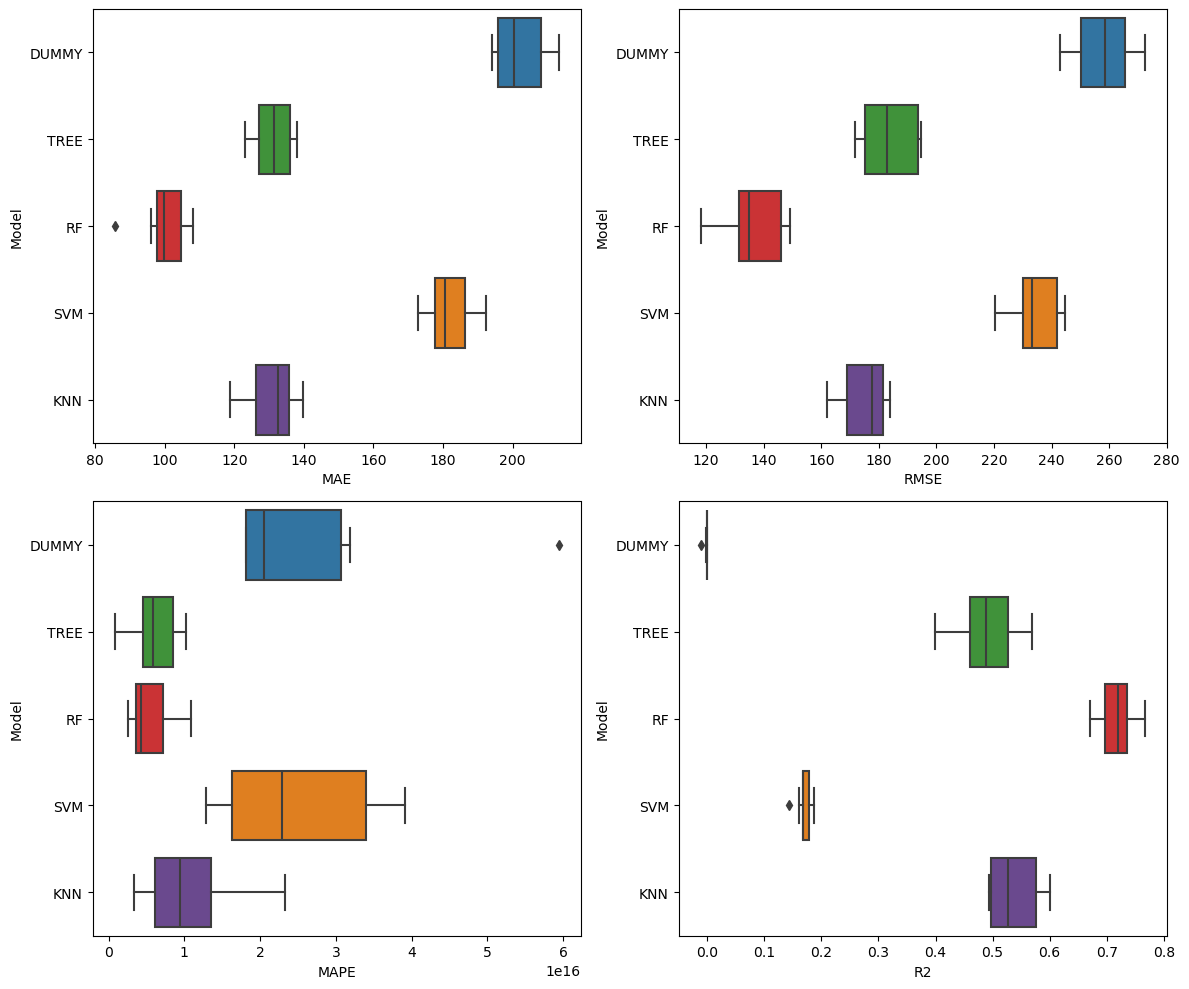

In [125]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
sns.boxplot(data=reg_metrics_new, x="MAE", y="Model", ax=axs[0, 0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics_new, x="RMSE", y="Model", ax=axs[0, 1], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics_new, x="MAPE", y="Model", ax=axs[1, 0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics_new, x="R2", y="Model", ax=axs[1, 1], palette=sns.color_palette('Paired')[1::2])


plt.tight_layout()
plt.show()

## Add vectorized text

In [126]:
X = merged_df
X.drop(columns=['processed text'], inplace=True)
X = scaler.fit_transform(X)
X = pd.DataFrame(X)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4977 entries, 0 to 4976
Columns: 1014 entries, 0 to 1013
dtypes: float64(1014)
memory usage: 38.5 MB


In [127]:
reg_metrics_text = pd.DataFrame(columns=['Model', 'MAE', 'RMSE', 'MAPE', 'R2'])

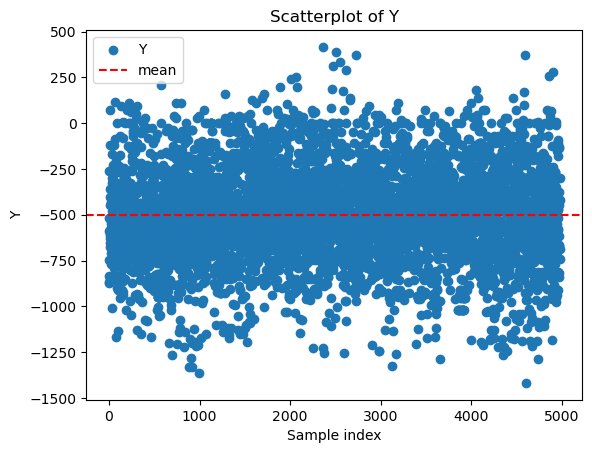

MSE Scores: 0    262.878351
1    261.429312
2    256.152181
3    257.656350
4    247.309473
5    266.639114
6    246.026549
7    256.444478
8    272.318555
9    250.848545
Name: RMSE, dtype: float64
Mean MSE: 257.77029087054257


In [128]:
dummy_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in dummy_kfolds.split(X):
    dummy_regressor = DummyRegressor()
    dummy_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_dummy_reg = dummy_regressor.predict(X.iloc[test_idx])
    current_dummy_mae = mean_absolute_error(Y.iloc[test_idx], y_dummy_reg)
    current_dummy_mse = mean_squared_error(Y.iloc[test_idx], y_dummy_reg)
    current_dummy_rmse = np.sqrt(current_dummy_mse)
    current_dummy_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_dummy_reg)
    current_dummy_r2 = r2_score(Y.iloc[test_idx], y_dummy_reg)
    reg_metrics_text.loc[len(reg_metrics_text)] = ['DUMMY', current_dummy_mae, current_dummy_rmse, current_dummy_mape, current_dummy_r2]

# Dovrebbe essere lo stesso di fare:
# lin_regressor = LinearRegression()
# Y_reshaped = Y.values.reshape(-1, 1)

# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(lin_regressor, np.ones_like(Y_reshaped), Y_reshaped,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(lin_regressor, np.ones_like(Y_reshaped), Y_reshaped, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(lin_regressor, np.ones_like(Y_reshaped), Y_reshaped, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics_text.loc[len(reg_metrics_text)] = ['DUMMY', mae_scores, mse_scores, mape_scores]


#Scatterplot of Y
mean_y = np.mean(Y)
plt.scatter(np.arange(len(Y)), Y, label='Y')
plt.axhline(y=mean_y, color='r', linestyle='--', label='mean')    # Plot the mean
plt.title('Scatterplot of Y')
plt.xlabel('Sample index')
plt.ylabel('Y')
plt.legend()
plt.show()

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics_text.loc[reg_metrics_text['Model']=='DUMMY','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics_text.loc[reg_metrics_text['Model']=='DUMMY','RMSE'])}")

In [129]:
# Decision Tree Regressor
# Initialize a decision tree regressor instance
tree_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in tree_kfolds.split(X):
    tree_regressor = DecisionTreeRegressor()
    tree_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_tree_reg = tree_regressor.predict(X.iloc[test_idx])
    current_tree_mae = mean_absolute_error(Y.iloc[test_idx], y_tree_reg)
    current_tree_mse = mean_squared_error(Y.iloc[test_idx], y_tree_reg)
    current_tree_rmse = np.sqrt(current_tree_mse)
    current_tree_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_tree_reg)
    current_tree_r2 = r2_score(Y.iloc[test_idx], y_tree_reg)
    reg_metrics_text.loc[len(reg_metrics_text)] = ['TREE', current_tree_mae, current_tree_rmse, current_tree_mape, current_tree_r2]

# Dovrebbe essere lo stesso di fare:
# rf = RandomForestRegressor()
#
# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(rd, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(rf, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(rf, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics_text.loc[len(reg_metrics_text)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics_text.loc[reg_metrics_text['Model']=='TREE','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics_text.loc[reg_metrics_text['Model']=='TREE','RMSE'])}")

MSE Scores: 10    172.721500
11    180.712029
12    180.793649
13    185.353359
14    179.626707
15    190.882507
16    173.698964
17    160.473655
18    172.221421
19    199.289815
Name: RMSE, dtype: float64
Mean MSE: 179.5773606470435


In [130]:
# Random Forest Regressor
# Initialize a random forest regressor instance
rf_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in rf_kfolds.split(X):
    rf_regressor = RandomForestRegressor(n_estimators=100, min_samples_leaf=100, random_state=42)
    rf_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_rf_reg = rf_regressor.predict(X.iloc[test_idx])
    current_rf_mae = mean_absolute_error(Y.iloc[test_idx], y_rf_reg)
    current_rf_mse = mean_squared_error(Y.iloc[test_idx], y_rf_reg)
    current_rf_rmse = np.sqrt(current_rf_mse)
    current_rf_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_rf_reg)
    current_rf_r2 = r2_score(Y.iloc[test_idx], y_rf_reg)
    reg_metrics_text.loc[len(reg_metrics_text)] = ['RF', current_rf_mae, current_rf_rmse, current_rf_mape, current_rf_r2]
     
# Dovrebbe essere lo stesso di fare:
# dummy_regressor = DummyRegressor()

# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(lin_regressor, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(lin_regressor, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(lin_regressor, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics_text.loc[len(reg_metrics_text)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics_text.loc[reg_metrics_text['Model']=='RF','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics_text.loc[reg_metrics_text['Model']=='RF','RMSE'])}")

MSE Scores: 20    158.547539
21    162.109986
22    166.552843
23    157.633533
24    156.628614
25    162.295148
26    163.095539
27    170.529384
28    160.636758
29    175.056009
Name: RMSE, dtype: float64
Mean MSE: 163.30853540526388


### TODO: STANDARDIZE THE COVARIATES FOR SVM!!!

In [131]:
sv_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in sv_kfolds.split(X):
    sv_regressor = SVR()
    sv_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_sv_reg = sv_regressor.predict(X.iloc[test_idx])
    current_sv_mae = mean_absolute_error(Y.iloc[test_idx], y_sv_reg)
    current_sv_mse = mean_squared_error(Y.iloc[test_idx], y_sv_reg)
    current_sv_rmse = np.sqrt(current_sv_mse)
    current_sv_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_sv_reg)
    current_sv_r2 = r2_score(Y.iloc[test_idx], y_sv_reg)
    reg_metrics_text.loc[len(reg_metrics_text)] = ['SVM', current_sv_mae, current_sv_rmse, current_sv_mape, current_sv_r2]

# Dovrebbe essere lo stesso di fare:
# sv_regressor = SVR()
#
# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(sv_regressor, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(sv_regressor, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(sv_regressor, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics_text.loc[len(reg_metrics_text)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics_text.loc[reg_metrics_text['Model']=='SVM','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics_text.loc[reg_metrics_text['Model']=='SVM','RMSE'])}")

MSE Scores: 30    252.326368
31    254.662807
32    260.065379
33    269.361377
34    255.567447
35    270.630120
36    260.473767
37    248.703999
38    247.725114
39    249.536738
Name: RMSE, dtype: float64
Mean MSE: 256.90531171469047


In [132]:
knn_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in knn_kfolds.split(X):
    knn_regressor = KNeighborsRegressor()
    knn_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_knn_reg = knn_regressor.predict(X.iloc[test_idx])
    current_knn_mae = mean_absolute_error(Y.iloc[test_idx], y_knn_reg)
    current_knn_mse = mean_squared_error(Y.iloc[test_idx], y_knn_reg)
    current_knn_rmse = np.sqrt(current_knn_mse)
    current_knn_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_knn_reg)
    current_knn_r2 = r2_score(Y.iloc[test_idx], y_knn_reg)
    reg_metrics_text.loc[len(reg_metrics_text)] = ['KNN', current_knn_mae, current_knn_rmse, current_knn_mape, current_knn_r2]

# Dovrebbe essere lo stesso di fare:
# knn_regressor = KNeighborsRegressor()
#
# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(knn_regressor, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(knn_regressor, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(knn_regressor, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics_new.loc[len(reg_metrics_new)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics_text.loc[reg_metrics_text['Model']=='KNN','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics_text.loc[reg_metrics_text['Model']=='KNN','RMSE'])}")

MSE Scores: 40    217.692303
41    232.234304
42    226.723928
43    228.744176
44    213.905516
45    216.398902
46    235.497704
47    222.632671
48    218.540860
49    221.795987
Name: RMSE, dtype: float64
Mean MSE: 223.41663502310067


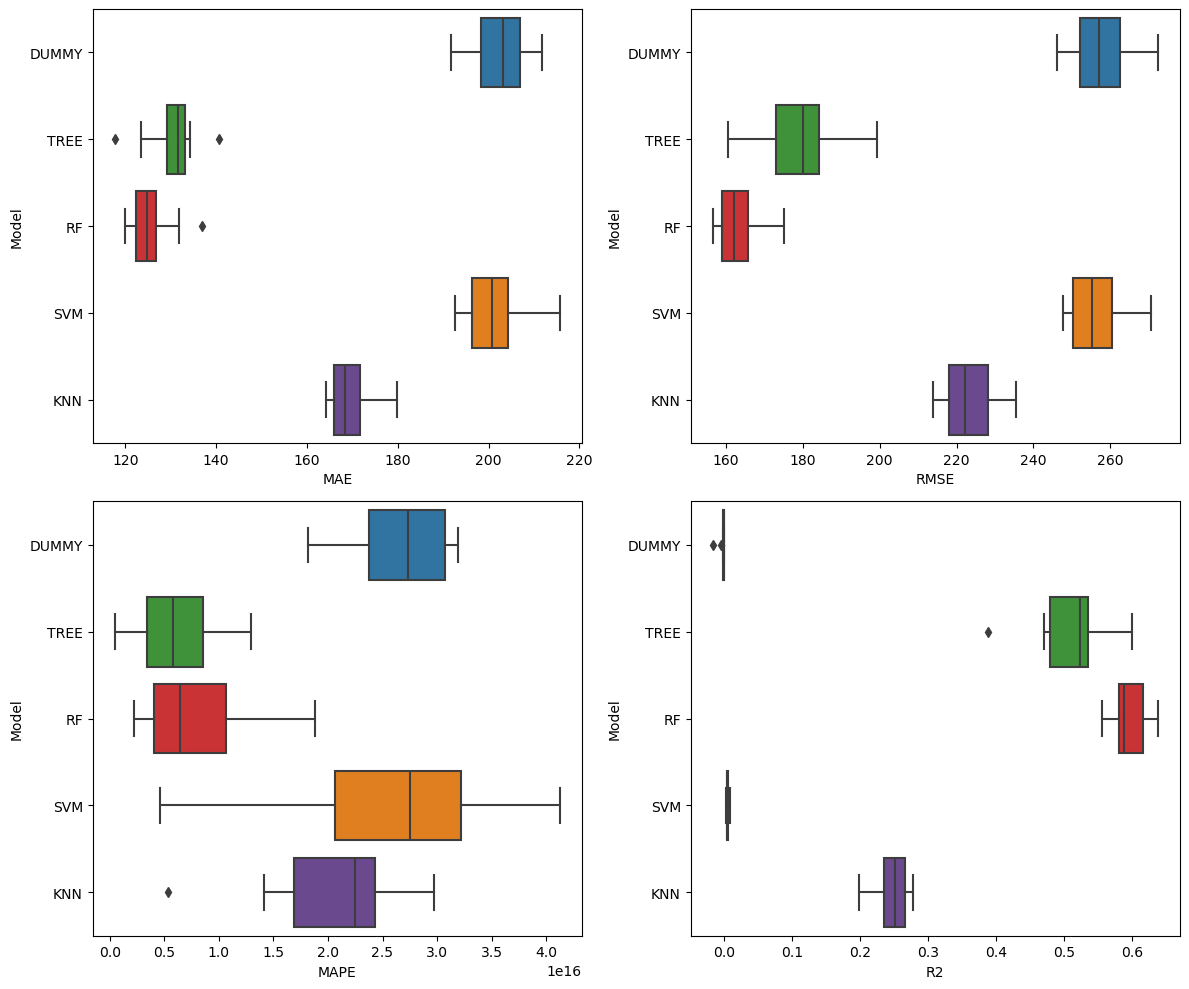

In [133]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
sns.boxplot(data=reg_metrics_text, x="MAE", y="Model", ax=axs[0, 0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics_text, x="RMSE", y="Model", ax=axs[0, 1], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics_text, x="MAPE", y="Model", ax=axs[1, 0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics_text, x="R2", y="Model", ax=axs[1, 1], palette=sns.color_palette('Paired')[1::2])


plt.tight_layout()
plt.show()

### Compare the three models

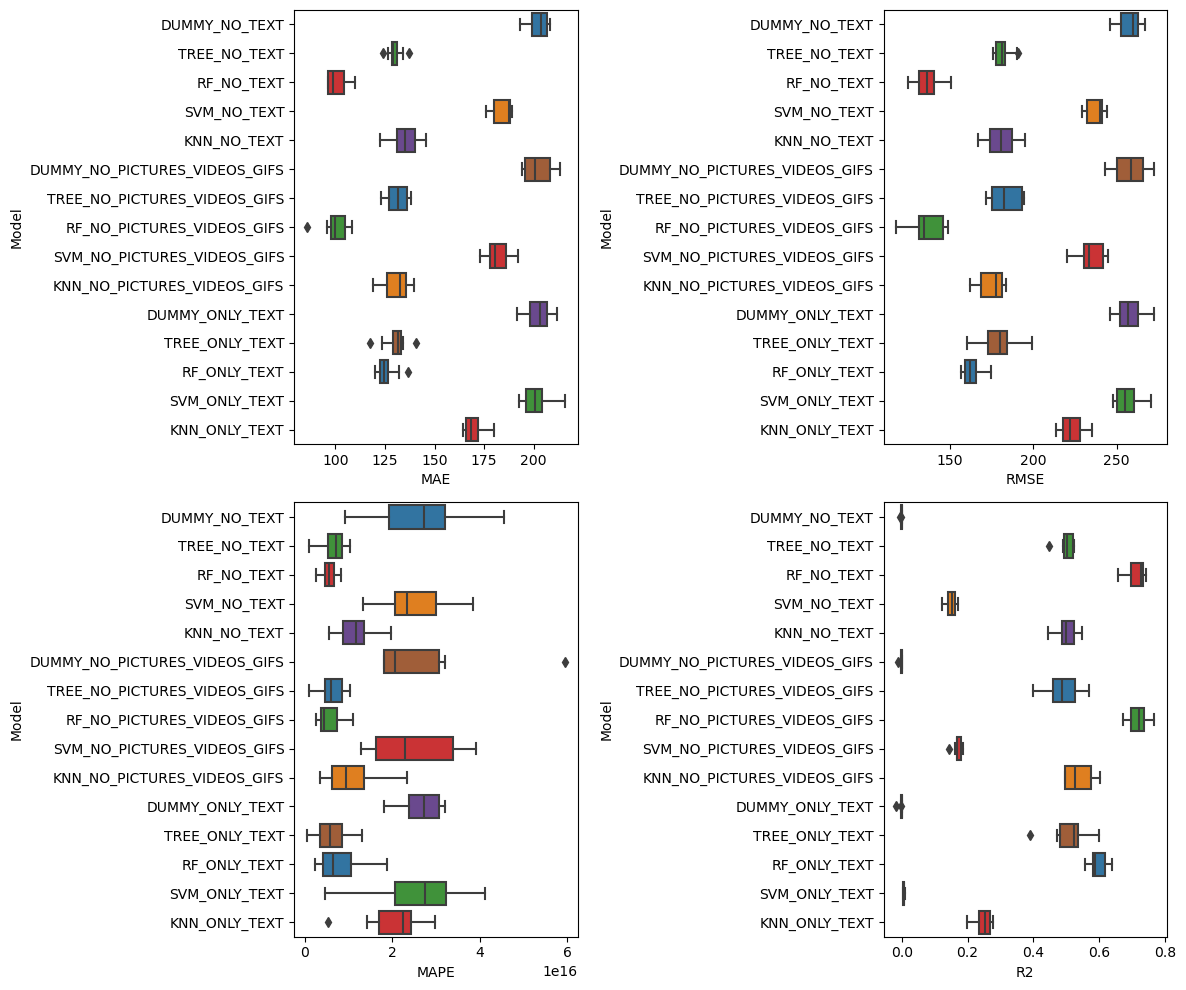

In [134]:
# Compare the results of the models with or without text features
reg_metrics['Model'] = reg_metrics['Model'] + '_NO_TEXT'
reg_metrics_new['Model'] = reg_metrics_new['Model'] + '_NO_PICTURES_VIDEOS_GIFS'
reg_metrics_text['Model'] = reg_metrics_text['Model'] + '_ONLY_TEXT'
reg_metrics = pd.concat([reg_metrics, reg_metrics_new, reg_metrics_text])
reg_metrics.reset_index(inplace=True, drop=True)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
sns.boxplot(data=reg_metrics, x="MAE", y="Model", ax=axs[0, 0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics, x="RMSE", y="Model", ax=axs[0, 1], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics, x="MAPE", y="Model", ax=axs[1, 0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics, x="R2", y="Model", ax=axs[1, 1], palette=sns.color_palette('Paired')[1::2])

plt.tight_layout()
plt.show()